In [1]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepims_clust import DeepClustering
from deepims_clust.pseudo_labeling import compute_dataset_ublb, pseudo_labeling
from deepims_clust.utils import size_adaption, size_adaption_symmetric

import umap
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
evaluation_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s'
                  ]

In [3]:
training_results = {}
training_images = {}
training_if = {}
polarity = '+'

sm = SMInstance()

for k in evaluation_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    training_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    training_images[k] = tmp
    training_if[k] = formula

100%|████████████████████████████████████████| 241/241 [00:00<00:00, 249.84it/s]


## Size adaption


In [4]:
[x.shape for x in training_images.values()]

[(245, 74, 84),
 (221, 88, 88),
 (194, 41, 78),
 (237, 56, 85),
 (276, 71, 82),
 (201, 35, 55),
 (186, 60, 44)]

In [5]:
padding_images = size_adaption_symmetric(training_images)
[x.shape for x in padding_images.values()]

[(245, 88, 88),
 (221, 88, 88),
 (194, 88, 88),
 (237, 88, 88),
 (276, 88, 88),
 (201, 88, 88),
 (186, 88, 88)]

## Ion overlap

In [6]:
tst = set(training_if['2022-12-07_02h13m50s']).intersection(set(training_if['2022-12-07_02h13m20s']), 
                                                          set(training_if['2022-12-07_02h10m45s']), 
                                                          set(training_if['2022-12-07_02h09m41s']), 
                                                          set(training_if['2022-12-07_02h08m52s']), 
                                                          set(training_if['2022-12-07_01h02m53s']), 
                                                          set(training_if['2022-12-07_01h01m06s']))

In [7]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 126


## Preparing data for training

In [8]:
training_dsid = [
    '2022-12-07_01h01m06s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s'
                  ]

testing_dsid = [
    '2022-12-07_02h13m50s'
]

In [9]:
training_data = []
training_datasets = [] 
training_ions = []

testing_data = []
testing_datasets = [] 
testing_ions = []


for dsid, imgs in padding_images.items():
    
    if dsid in training_dsid:
        training_data.append(imgs)
        training_datasets += [dsid] * imgs.shape[0]
        training_ions += training_if[dsid]
    
    testing_data.append(imgs)
    testing_datasets += [dsid] * imgs.shape[0]
    testing_ions += training_if[dsid]
        
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

testing_data = np.concatenate(testing_data)
testing_datasets = np.array(testing_datasets)
testing_ions = np.array(testing_ions)

# Building full torch model

## Making complete torchloss 

Testing all parts:
* ub/lb
* Ds specific ub/lb
* pseudo labeling

In [10]:
model = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=8,
                initial_upper=93,
                initial_lower=37,
                upper_iteration=1.5,
                lower_iteration=1.5,
                dataset_specific_percentiles=True,
                random_flip=True,
                knn=True, k=5,
                lr=0.0001, batch_size=128,
                pretraining_epochs=1,
                training_epochs=16,
                cae_encoder_dim=20,
                use_gpu=True,
                random_seed=1225
            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [11]:
train_x, index, train_datasets, train_ions = model.get_new_batch()
train_x = train_x.to(model.device)

cae, clust, optimizer = model.initialize_models()

optimizer.zero_grad()
x_p = cae(train_x)

features = clust(x_p)
uu = 85
ll=55

CAE Final conv size = 3136
CNNClust final conv dim = 289


In [12]:
# ublb
import torch.nn.functional as functional
import torch

def original_ublb(model, features, uu, ll, train_datasets, index):
    features = functional.normalize(features, p=2, dim=-1)
    features = features / features.norm(dim=1)[:, None]

    sim_mat = torch.matmul(features, torch.transpose(features, 0, 1))

    sim_numpy = sim_mat.cpu().detach().numpy()

    # Get all sim values from the batch excluding the diagonal
    tmp2 = [sim_numpy[i][j] for i in range(0, model.batch_size)
            for j in range(model.batch_size) if i != j]

    ub = np.percentile(tmp2, uu)
    lb = np.percentile(tmp2, ll)

    return ub, lb, sim_numpy, sim_mat

# Testing
oub, olb, sim_numpy, smn = original_ublb(model, features=features, uu=uu, ll=ll, train_datasets=train_datasets, index=index)
tub, tlb, sim_mat = model.compute_ublb(features=features, uu=uu, ll=ll, train_datasets=train_datasets, index=index)

assert tub > tlb
assert oub > olb

assert oub == tub
assert olb == tlb

In [13]:
# Dataset ub/lb
def original_dataset_ublb(sim_mat: np.ndarray, ds_labels: np.ndarray,
                         lower_bound: int, upper_bound: int):
    ds_ub = {}
    ds_lb = {}
    for dst in torch.unique(ds_labels):
        ds = float(dst.detach().cpu().numpy())
        curr_sim = [sim_mat[i][j] for i in range(0, sim_mat.shape[0])
                    for j in range(sim_mat.shape[0]) if (i != j and ds_labels[i] == ds and ds_labels[j] == ds)]

        if len(curr_sim) > 2:
            ds_ub[ds] = np.percentile(curr_sim, upper_bound)
            ds_lb[ds] = np.percentile(curr_sim, lower_bound)
        else:
            ds_ub[ds] = 1
            ds_lb[ds] = 0

    return ds_ub, ds_lb

ods_ub, ods_lb = original_dataset_ublb(sim_numpy, ds_labels=train_datasets, lower_bound=ll, upper_bound=uu)
ods_ubv = [ods_ub[x] for x in range(len(ods_ub))]
ods_lbv = [ods_lb[x] for x in range(len(ods_lb))]

tds_ub, tds_lb = compute_dataset_ublb(sim_mat, ds_labels=train_datasets, lower_bound=ll, upper_bound=uu)

assert all((tds_ub - tds_lb) >= 0)
assert all([np.round(float(tds_ub[x].cpu().numpy()), 3)==np.round(ods_ubv[x], 3) for x in range(tds_ub.size(0))])
assert all([np.round(float(tds_lb[x].cpu().numpy()), 3)==np.round(ods_lbv[x], 3) for x in range(tds_lb.size(0))])

tensor([5, 5, 0, 5, 3, 1, 4, 0, 5, 1, 4, 4, 0, 5, 4, 0, 2, 2, 1, 1, 1, 2, 3, 5,
        1, 2, 5, 1, 2, 0, 3, 3, 1, 3, 1, 2, 5, 3, 0, 4, 5, 1, 2, 3, 2, 0, 2, 3,
        5, 4, 4, 4, 5, 2, 0, 3, 5, 0, 0, 5, 3, 1, 4, 1, 1, 3, 0, 5, 4, 2, 0, 0,
        2, 3, 2, 5, 3, 5, 0, 1, 5, 4, 3, 5, 5, 2, 1, 2, 0, 4, 5, 1, 3, 2, 2, 4,
        4, 1, 2, 5, 5, 3, 5, 3, 2, 0, 3, 4, 4, 1, 3, 5, 4, 0, 2, 1, 4, 1, 0, 5,
        5, 1, 5, 1, 0, 2, 1, 5], device='cuda:0')


In [14]:
# Pseudo labeling
def original_ps(ub: float, lb: float,
                sim: torch.tensor,
                index: np.ndarray,
                ion_label_mat: np.ndarray,
                knn: bool, knn_adj: np.ndarray = None,
                dataset_specific_percentiles: bool = False,
                dataset_ub: dict = None,
                dataset_lb: dict = None,
                ds_labels: np.ndarray = None):

    if dataset_specific_percentiles:
        
        ub_m = np.ones(sim.shape)
        # TODO: should be zero matrix for lower bound probably, rethink that!
        lb_m = np.zeros(sim.shape)
        for dst in torch.unique(ds_labels):
            ds = float(dst.detach().cpu().numpy())
            ds_v = ds_labels == ds
            ub_m[np.ix_(ds_v.cpu().numpy(), ds_v.cpu().numpy())] = dataset_ub[ds]
            lb_m[np.ix_(ds_v.cpu().numpy(), ds_v.cpu().numpy())] = dataset_lb[ds]

        pos_loc = (sim >= ub_m).astype("float64")
        neg_loc = (sim <= lb_m).astype("float64")

    else:
        pos_loc = (sim >= ub).astype("float64")
        neg_loc = (sim <= lb).astype("float64")

    # Align images within KNN
    if knn:
        knn_submat = knn_adj[np.ix_(index.cpu().numpy(), index.cpu().numpy())]
        # Todo: Not 100% sure with this one, should be checked again
        pos_loc = np.maximum(pos_loc, knn_submat)
        neg_loc = np.minimum(neg_loc, 1-knn_submat)

    # Align the same ions
    ion_submat = ion_label_mat[np.ix_(index.cpu().numpy(), index.cpu().numpy())]
    pos_loc = np.maximum(pos_loc, ion_submat)
    neg_loc = np.minimum(neg_loc, 1 - ion_submat)

    pos_loc = torch.tensor(pos_loc)
    neg_loc = torch.tensor(neg_loc)

    return pos_loc, neg_loc

# no KNN, no DS percentiles
opl, onl = original_ps(ub=oub, lb=olb, sim=sim_numpy, index=index, knn=False,
                       knn_adj=model.knn_adj.cpu().numpy(), ion_label_mat=model.ion_label_mat.cpu().numpy(),
                       dataset_specific_percentiles=False,
                       dataset_ub=ods_ub, dataset_lb=ods_lb,
                       ds_labels=train_datasets)
assert not ((opl.cpu().numpy() + onl.cpu().numpy())==2).any()
tpl, tnl = pseudo_labeling(ub=tub, lb=tlb, sim=sim_mat, index=index, knn=False,
                       knn_adj=model.knn_adj, ion_label_mat=model.ion_label_mat,
                       dataset_specific_percentiles=False,
                       dataset_ub=tds_ub, dataset_lb=tds_lb,
                       ds_labels=train_datasets, device=model.device)
assert not ((tpl.cpu().numpy() + tnl.cpu().numpy())==2).any()
assert (tpl.cpu().numpy() == opl.cpu().numpy()).all()
assert (tnl.cpu().numpy() == onl.cpu().numpy()).all()
tnl1 = tnl

# no KNN, DS percentiles
opl, onl = original_ps(ub=oub, lb=olb, sim=sim_numpy, index=index, knn=False,
                       knn_adj=model.knn_adj.cpu().numpy(), ion_label_mat=model.ion_label_mat.cpu().numpy(),
                       dataset_specific_percentiles=True,
                       dataset_ub=ods_ub, dataset_lb=ods_lb,
                       ds_labels=train_datasets)
assert not ((opl.cpu().numpy() + onl.cpu().numpy())==2).any()
tpl, tnl = pseudo_labeling(ub=tub, lb=tlb, sim=sim_mat, index=index, knn=False,
                       knn_adj=model.knn_adj, ion_label_mat=model.ion_label_mat,
                       dataset_specific_percentiles=True,
                       dataset_ub=tds_ub, dataset_lb=tds_lb,
                       ds_labels=train_datasets, device=model.device)
assert not ((tpl.cpu().numpy() + tnl.cpu().numpy())==2).any()
assert (tpl.cpu().numpy() == opl.cpu().numpy()).all()
assert (tnl.cpu().numpy() == onl.cpu().numpy()).all()



# KNN, no DS percentiles
opl, onl = original_ps(ub=oub, lb=olb, sim=sim_numpy, index=index, knn=True,
                       knn_adj=model.knn_adj.cpu().numpy(), ion_label_mat=model.ion_label_mat.cpu().numpy(),
                       dataset_specific_percentiles=False,
                       dataset_ub=ods_ub, dataset_lb=ods_lb,
                       ds_labels=train_datasets)
assert not ((opl.cpu().numpy() + onl.cpu().numpy())==2).any()
tpl, tnl = pseudo_labeling(ub=tub, lb=tlb, sim=sim_mat, index=index, knn=True,
                       knn_adj=model.knn_adj, ion_label_mat=model.ion_label_mat,
                       dataset_specific_percentiles=False,
                       dataset_ub=tds_ub, dataset_lb=tds_lb,
                       ds_labels=train_datasets, device=model.device)
assert not ((tpl.cpu().numpy() + tnl.cpu().numpy())==2).any()
assert (tpl.cpu().numpy() == opl.cpu().numpy()).all()
assert (tnl.cpu().numpy() == onl.cpu().numpy()).all()




# KNN, DS percentiles
opl, onl = original_ps(ub=oub, lb=olb, sim=sim_numpy, index=index, knn=True,
                       knn_adj=model.knn_adj.cpu().numpy(), ion_label_mat=model.ion_label_mat.cpu().numpy(),
                       dataset_specific_percentiles=True,
                       dataset_ub=ods_ub, dataset_lb=ods_lb,
                       ds_labels=train_datasets)

assert not ((opl.cpu().numpy() + onl.cpu().numpy())==2).any()
tpl, tnl = pseudo_labeling(ub=tub, lb=tlb, sim=sim_mat, index=index, knn=True,
                       knn_adj=model.knn_adj, ion_label_mat=model.ion_label_mat,
                       dataset_specific_percentiles=True,
                       dataset_ub=tds_ub, dataset_lb=tds_lb,
                       ds_labels=train_datasets, device=model.device)
assert not ((tpl.cpu().numpy() + tnl.cpu().numpy())==2).any()
assert (tpl.cpu().numpy() == opl.cpu().numpy()).all()
assert (tnl.cpu().numpy() == onl.cpu().numpy()).all()

# Just to double checking
assert not (tnl.cpu().numpy() == tnl1.cpu().numpy()).all()

In [15]:
# Loss

# Origina
optimizer.zero_grad()
loub, olb, sim_numpy, smn = original_ublb(model, features=features, uu=uu, ll=ll, train_datasets=train_datasets, index=index)
ods_ub, ods_lb = original_dataset_ublb(sim_numpy, ds_labels=train_datasets, lower_bound=ll, upper_bound=uu)
opl, onl = original_ps(ub=oub, lb=olb, sim=sim_numpy, index=index, knn=True,
                       knn_adj=model.knn_adj.cpu().numpy(), ion_label_mat=model.ion_label_mat.cpu().numpy(),
                       dataset_specific_percentiles=True,
                       dataset_ub=ods_ub, dataset_lb=ods_lb,
                       ds_labels=train_datasets)

l1 = model.cl(opl.to(model.device), onl.to(model.device), sim_mat = smn)
l1.backward(retain_graph=True)
g1 = torch.gradient(smn)[0].cpu().detach().numpy()

# Torch
optimizer.zero_grad()
tub, tlb, sim_mat =  model.compute_ublb(features=features, uu=uu, ll=ll, train_datasets=train_datasets, index=index)
tds_ub, tds_lb = compute_dataset_ublb(sim_mat, ds_labels=train_datasets, lower_bound=ll, upper_bound=uu)
tpl, tnl = pseudo_labeling(ub=tub, lb=tlb, sim=sim_mat, index=index, knn=True,
                       knn_adj=model.knn_adj, ion_label_mat=model.ion_label_mat,
                       dataset_specific_percentiles=True,
                       dataset_ub=tds_ub, dataset_lb=tds_lb,
                       ds_labels=train_datasets, device=model.device)

l2 = model.cl(tpl, tnl, sim_mat = sim_mat)
l2.backward(retain_graph=True)
g2 = torch.gradient(sim_mat)[0].cpu().detach().numpy()

assert l1 == l2
assert (g1 == g2).all()

tensor([5, 5, 0, 5, 3, 1, 4, 0, 5, 1, 4, 4, 0, 5, 4, 0, 2, 2, 1, 1, 1, 2, 3, 5,
        1, 2, 5, 1, 2, 0, 3, 3, 1, 3, 1, 2, 5, 3, 0, 4, 5, 1, 2, 3, 2, 0, 2, 3,
        5, 4, 4, 4, 5, 2, 0, 3, 5, 0, 0, 5, 3, 1, 4, 1, 1, 3, 0, 5, 4, 2, 0, 0,
        2, 3, 2, 5, 3, 5, 0, 1, 5, 4, 3, 5, 5, 2, 1, 2, 0, 4, 5, 1, 3, 2, 2, 4,
        4, 1, 2, 5, 5, 3, 5, 3, 2, 0, 3, 4, 4, 1, 3, 5, 4, 0, 2, 1, 4, 1, 0, 5,
        5, 1, 5, 1, 0, 2, 1, 5], device='cuda:0')


## Training model

In [19]:
model = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=8,
                initial_upper=93,
                initial_lower=37,
                upper_iteration=1.,
                lower_iteration=1.,
                dataset_specific_percentiles=True,
                random_flip=True,
                knn=True, k=5,
                lr=0.0001, batch_size=128,
                pretraining_epochs=10,
                training_epochs=16,
                cae_encoder_dim=20,
                use_gpu=True,
                random_seed=1225
            )

After 16 epochs, the upper bound will be: 77.0.
After 16 epochs, the lower bound will be: 53.0.


In [20]:
model.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 00 Training Loss: 0.142479 | Validation Loss: 0.032733
Pretraining Epoch: 01 Training Loss: 0.053283 | Validation Loss: 0.028753
Pretraining Epoch: 02 Training Loss: 0.034793 | Validation Loss: 0.026450
Pretraining Epoch: 03 Training Loss: 0.028295 | Validation Loss: 0.024969
Pretraining Epoch: 04 Training Loss: 0.024265 | Validation Loss: 0.023173
Pretraining Epoch: 05 Training Loss: 0.022027 | Validation Loss: 0.021325
Pretraining Epoch: 06 Training Loss: 0.019911 | Validation Loss: 0.019308
Pretraining Epoch: 07 Training Loss: 0.017928 | Validation Loss: 0.018384
Pretraining Epoch: 08 Training Loss: 0.016828 | Validation Loss: 0.016741
Pretraining Epoch: 09 Training Loss: 0.015517 | Validation Loss: 0.015514
Epoch: 00 | CAE-Loss: 0.015325 | CNN-Loss: 0.600275 | Total loss: 15.925449
  * Val:  | CAE-Loss: 0.015696 | CNN-Loss: 15.866949
Epoch: 01 | CAE-Loss: 0.014374 | CNN-Loss: 0.432322 | Total loss: 14.80639

0

## Evaluation

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


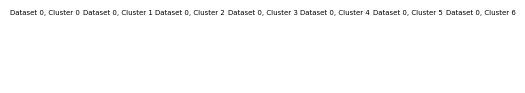

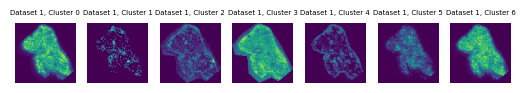

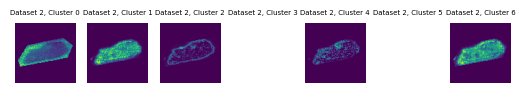

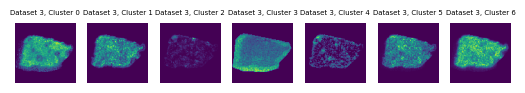

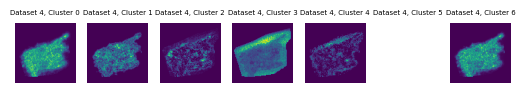

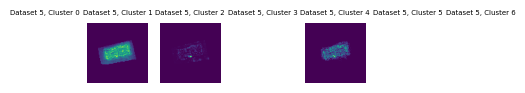

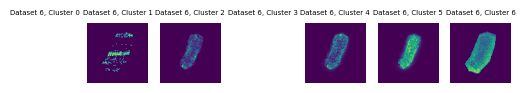

In [21]:
pred_labels = model.inference()

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    ds_imgs = model.image_data[model.dataset_labels==ds]
    curr_labels = pred_labels[model.dataset_labels==ds]

    cluster_ion_images = []
    for cluster in set(pred_labels):
        cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
    fig, axs = plt.subplots(ncols=len(set(pred_labels)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1

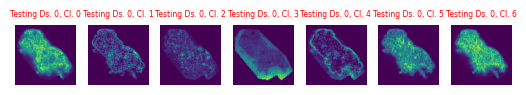

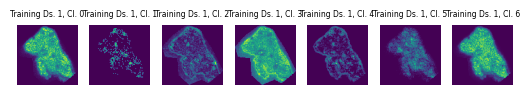

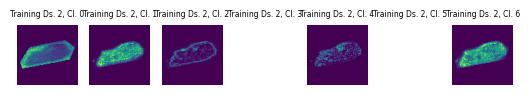

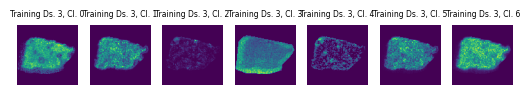

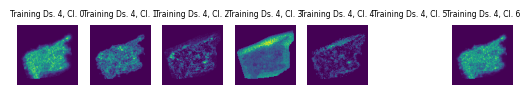

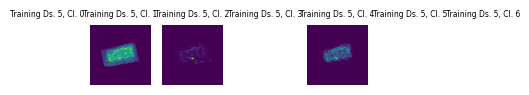

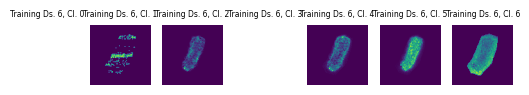

In [22]:
pred_labels = model.inference(new_data=testing_data)

image_dat = model.image_normalization(new_data=testing_data)

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    
        ds_imgs = image_dat[testing_datasets==ds]
        curr_labels = pred_labels[testing_datasets==ds]

        cluster_ion_images = []
        for cluster in set(pred_labels):
            cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
        fig, axs = plt.subplots(ncols=len(set(pred_labels)))
        counter = 0
        for ax, im in zip(axs, cluster_ion_images):
            ax.imshow(im)
            ax.axis('off')
            if ds in testing_dsid:
                ax.set_title(f'Testing Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5}, color= 'red')
            else:
                ax.set_title(f'Training Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5})
            counter += 1
        plt.show()
        ds_counter += 1

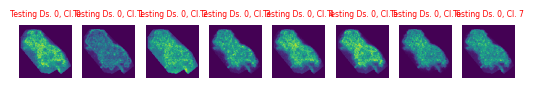

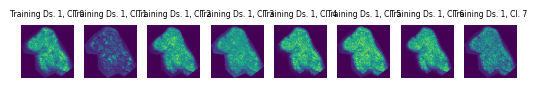

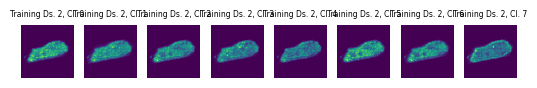

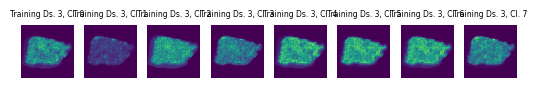

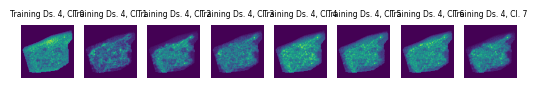

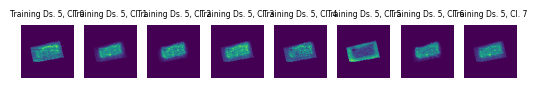

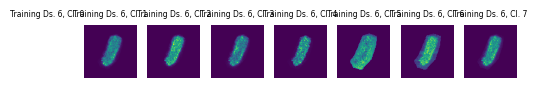

In [23]:
pred_labels = model.inference(cae, clust, new_data=testing_data)

image_dat = model.image_normalization(new_data=testing_data)

# Loop over datasets:
ds_counter = 0
for ds in evaluation_datasets:
    
        ds_imgs = image_dat[testing_datasets==ds]
        curr_labels = pred_labels[testing_datasets==ds]

        cluster_ion_images = []
        for cluster in set(pred_labels):
            cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
        fig, axs = plt.subplots(ncols=len(set(pred_labels)))
        counter = 0
        for ax, im in zip(axs, cluster_ion_images):
            ax.imshow(im)
            ax.axis('off')
            if ds in testing_dsid:
                ax.set_title(f'Testing Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5}, color= 'red')
            else:
                ax.set_title(f'Training Ds. {ds_counter}, Cl. {counter}', fontdict={'fontsize': 5.5})
            counter += 1
        plt.show()
        ds_counter += 1